## Model Development & Training Notebook (without considering tree cover)

This notebook is used to train and evaluate a feed-foward neural network used for binary classification (formal | informal) based on OBI building data obtained from the previous notebooks. Starts by importing the required libraries, clearing any previous tuning results, and loading the prepared training dataset. The data is then cleaned by removing unnecessary columns, filling missing values, and normalizing the average area, maximum area, and average height.


The data is split into training and test sets (80% training, 20% testing), and the features are standardized (using `StandardScaler()` to improve model stability. A feed-forward neural network with two hidden layers is then built and tuned using Keras Tuner, which automatically searches for the best hyperparameter combinations while early stopping prevents overfitting. Once the best configuration is found, the model is trained and evaluated using accuracy, loss, confusion matrix, and a classification report (saved for reference). Finally, the fitted scaler and the trained model (in .save and .keras formats) are exported for later use in the inference notebook. 

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
#%pip install keras_tuner
import keras_tuner as kt
from tensorflow.keras import Input
from tensorflow.keras import backend as K
import shutil

shutil.rmtree("kt_dir", ignore_errors=True)
K.clear_session()

In [12]:
# name of city - used only in output file name
city = "Nairobi"
# load result from 2.0 training_to_parquet
training_data_file = r"Kenya_mock_training_data.parquet"  # "enhanced_formal.parquet"

# define name/path where classification report should be saved - no extension -> will be added in the code
classification_rpt = r"classification_report"

# define name/path where confusion matrix should be saved.
confusion_mtrx = r"confusion matrix"


#### Train Data Set

In [13]:
# load result from 2.0 training_to_parquet
df = pd.read_parquet(training_data_file)

#drop unused columns, leave only the ones needed for computation
df_adjusted = df.drop(
    columns=["id", "geometry", "polygon"]
)

df_cleaned = df_adjusted.fillna(0)


# Normalize data
df_cleaned["avg_area_norm"] = df_cleaned["avg_area"] / 3000
df_cleaned.loc[df_cleaned["avg_area"] > 3000, "avg_area_norm"] = 1

df_cleaned["max_area_norm"] = df_cleaned["max_area"] / 3000
df_cleaned.loc[df_cleaned["max_area"] > 3000, "max_area_norm"] = 1

df_cleaned["avg_height_norm"] = df_cleaned["avg_height"] / 100
df_cleaned.loc[df_cleaned["avg_height"] > 3000, "avg_height_norm"] = 1

df_cleaned = df_cleaned.drop(columns=["avg_area", "max_area", "avg_height"])



In [14]:
print(list(df_cleaned.columns))

['class', 'count', 'avg_area_norm', 'max_area_norm', 'avg_height_norm']


In [15]:
# Separate features (X) and label (y)
X = df_cleaned.drop("class", axis=1)
y = df_cleaned["class"]

y = y.map({"formal": 0, "informal": 1})

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

input_dim = X_train.shape[1]

def build_model(hp):
    model = Sequential()

    model.add(Input(shape=(input_dim,)))

    # First hidden layer
    model.add(Dense(24, activation="relu", name="dense_0"))

    # Second hidden layers
    model.add(Dense(88, activation="relu", name="dense_1"))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Set up early stopping
earlystopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Try 10 different combinations
    executions_per_trial=1,
    directory='kt_dir',
    project_name='text_classifier_tuning'
)

# Run search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.1,
    callbacks=[earlystopping],
    verbose=1
)

# Get the best model
model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")
model.summary()

Trial 1 Complete [00h 00m 11s]
val_accuracy: 0.9596977233886719

Best val_accuracy So Far: 0.9596977233886719
Total elapsed time: 00h 00m 11s


/usr/local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9546 - loss: 0.1398
Test Accuracy: 0.9546
Test Loss: 0.1398


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 88)             │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            89 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,409 (9.41 KB)

 Trainable params: 2,409 (9.41 KB)

 Non-trainable params: 0 (0.00 B)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


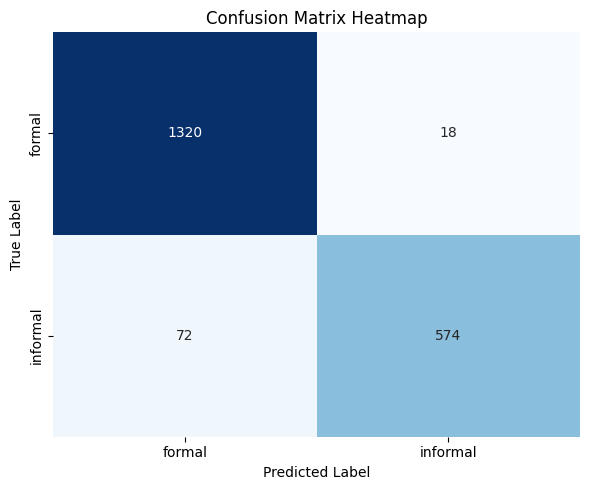

In [16]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["formal", "informal"],
    yticklabels=["formal", "informal"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")

# Save IMAGE to file
plt.tight_layout()
plt.savefig(confusion_mtrx, dpi=300)

plt.show()
plt.close()

In [17]:
from sklearn.metrics import classification_report

# Print the classification report
report = classification_report(y_test, y_pred, target_names=["formal", "informal"])
print(report)

with open(f"{classification_rpt}_{city}.txt", "w") as f:
    f.write(report)

              precision    recall  f1-score   support

      formal       0.95      0.99      0.97      1338
    informal       0.97      0.89      0.93       646

    accuracy                           0.95      1984
   macro avg       0.96      0.94      0.95      1984
weighted avg       0.96      0.95      0.95      1984



In [18]:
# === Save trained model and scaler (for use during inference)===
import joblib
import os

# Define output directory
save_dir = "model"
os.makedirs(save_dir, exist_ok=True)

# 1. Save the scaler
scaler_path = os.path.join(save_dir, "scaler.save")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 2. Save the trained model
model_path = os.path.join(save_dir, "trained_model.keras")
model.save(model_path)
print(f"Trained model saved to: {model_path}")


Scaler saved to: model/scaler.save
Trained model saved to: model/trained_model.keras
